# Project part A

Imports

In [3]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
from tqdm.asyncio import trange, tqdm
import asyncio
import aiohttp  # requires cchardet package

plt.rcParams['figure.figsize'] = [10, 8]

If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

## Downloading the data

In [13]:
## Util functions ##

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def flatten(l):
    return [item for sublist in l for item in sublist]

## Data download ##

# Category pages

def get_category_pages_query(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=1000"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    return query

def handle_category_pages_return(wikitext_json):

    categories_list = wikitext_json["query"]["categorymembers"]

    return categories_list

# Title search

def get_wiki_pages_with_prefix_query(prefix, namespace_id):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=allpages"
    dataformat ="format=json&aplimit=500"
    apprefix = "apprefix=" + urllib.parse.quote_plus(prefix)
    apnamespace = "apnamespace=" + str(namespace_id)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, apprefix, apnamespace, dataformat)

    return query

def handle_wiki_pages_with_prefix_return(wikitext_json):

    title_list_raw = wikitext_json["query"]["allpages"]

    if len(title_list_raw) > 0:
        title_list = [entry["title"] for entry in title_list_raw]
    else:
        title_list = []

    return title_list

# Wiki pages

def get_wiki_data_query(titles):
    # Can handle multiple titles
    if isinstance(titles, list):
        titlestring = "|".join(titles)
    else:
        titlestring = titles

    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(titlestring)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    return query

def parse_page(page):

    # Does page exist?
    if "revisions" in page:
        content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
        title = page["title"]

        # Normalize whitespace
        content = re.sub(r'[\n\t\ ]+', ' ', content)

        # Retreive links to User: pages
        links = re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content) # Previous: '\[([^\]\[\|:]+)[\]\|]'
        filtered_links = np.unique(links)

        origin_title_list = re.findall('([^/]+).*', title)
        if len(origin_title_list) > 0:
            origin_title = origin_title_list[0]
        else:
            origin_title = title
        
        # Article word count
        #word_count = len(re.findall('\w+', content.lower()))
        #graph.nodes(data=True)[title]["word_count"] = word_count

        # Obsolete Heuristic for Archive pages
        #archive_number = re.findall('\|\s*counter\s*=\s*([^\|\}\s]+)', content)

        return {"origin_title": origin_title, "user_links": filtered_links}
    else:
        return None

def handle_wiki_data_return(wikitext_json):

    pages = wikitext_json["query"]["pages"]

    return pages

# HTTP Request handling

def send_urlib_request_sync(query):
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    return wikitext_json

async def send_urlib_request_async(query, callback=None):
    async with aiohttp.ClientSession() as session:
        async with session.get(query) as response:
            html = await response.text()
            wikitext_json = json.loads(html)
            if callback is None:
                results = wikitext_json
            else:
                results = callback(wikitext_json)

    return results

async def handle_queries(queries, callback=None, tqdm_desc=None):
    coroutines = [send_urlib_request_async(query, callback) for query in queries]
    wikitexts = await tqdm.gather(*coroutines, desc=tqdm_desc)

    return wikitexts

# Scraper

async def scrape_wiki(category_titles, verbose=True):
    # Constants
    wiki_api_page_request_limit = 50
    namespace_id_talk = 1


    # Get pages in category
    category_queries = [get_category_pages_query(category_title) for category_title in category_titles]
    # Send requests
    pages = await handle_queries(category_queries, callback=handle_category_pages_return, tqdm_desc="Fetching " + str(len(category_titles)) + " categories")
    # Handle results
    titles = [r["title"] for page in pages for r in page]
    # Filter only Talk pages
    filtered_titles = [title for title in titles if "Talk:" in title] # Todo might be worth using regex here


    # Find archive pages
    archive_queries = [get_wiki_pages_with_prefix_query(title.replace("Talk:", "") + "/Archive", namespace_id_talk) for title in filtered_titles]
    # Send requests
    archive_titles = await handle_queries(archive_queries, callback=handle_wiki_pages_with_prefix_return, tqdm_desc="Fetching " + str(len(filtered_titles)) + " page archive titles")
    archive_titles = flatten(archive_titles)

    # List of all pages to gather
    all_titles = filtered_titles + archive_titles


    # Split list because of API limits
    split_titles_list = list(chunks(all_titles, wiki_api_page_request_limit))

    # Get wiki pages
    wiki_page_queries = [get_wiki_data_query(titles) for titles in split_titles_list]
    # Send requests
    pages = await handle_queries(wiki_page_queries, callback=handle_wiki_data_return, tqdm_desc="Fetching " + str(len(all_titles)) + " pages")

    # Parse pages
    data = []
    for sublist in tqdm(pages, desc="Parsing page batches"): # TODO parallelize if possible
        parse_results = [parse_page(page_content) for key, page_content in sublist.items()]
        data += parse_results

    # Graph
    page_graph = nx.DiGraph()
    for page in filtered_titles:
        page_graph.add_node(page, page_class="talk")

    count = 0
    # Add User: links to graph
    for page_data in tqdm(data, desc="Creating graph"):
        if page_data is not None:
            if page_data["origin_title"] in page_graph:
                for link in page_data["user_links"]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class="user")
                    page_graph.add_edge(link, page_data["origin_title"])
                    count += 1
            #else:
            #    print(origin_title) # Talk:HIV for some reason

    print("Total edges: " + str(count))

    return page_graph


category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph = await scrape_wiki(category_titles)

Creating graph: 100%|██████████| 4767/4767 [00:00<00:00, 12100.21it/s]

Total edges: 134144


/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  func(*args, **kwargs)
/Users/zimmer/opt/anaconda3/envs/socialgraphs/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  fun

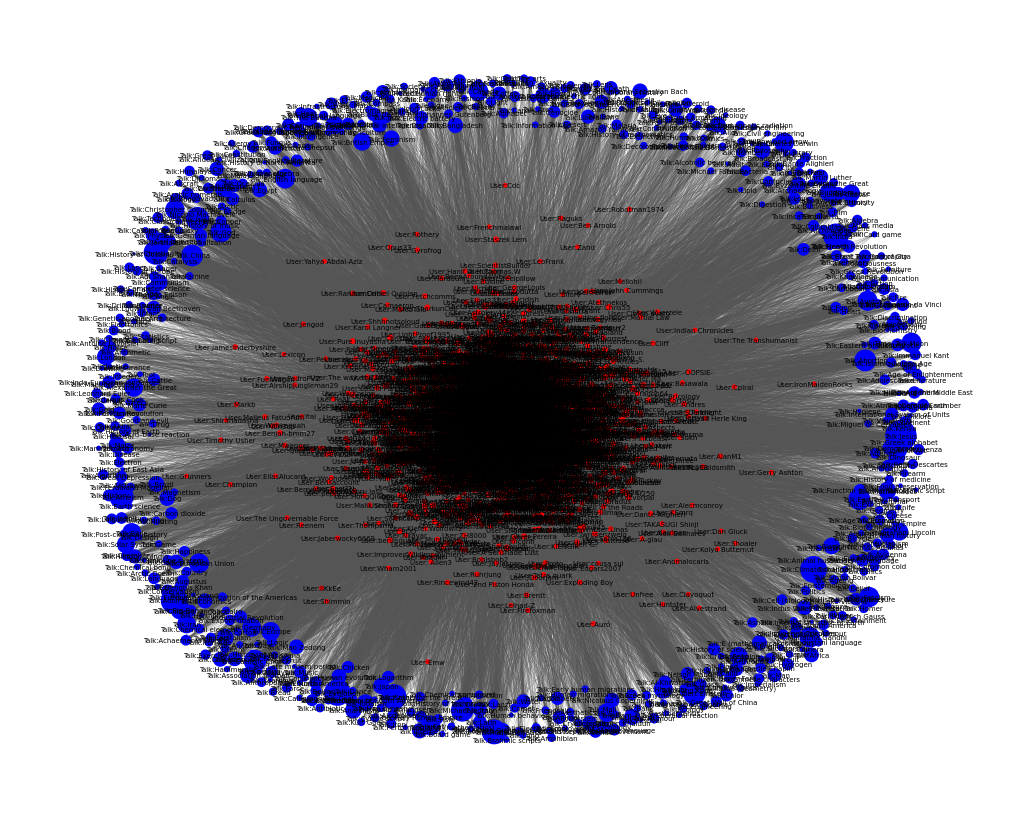

In [9]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 5:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

## Basic Analysis

## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)
> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)
> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?